This code has largely been copied from [A primer on deep learning in genomics](https://www.nature.com/articles/s41588-018-0295-5) (Zou _et al._, 2018), with adjustments made for working with a subset of the _Skeletonema marinoi_ microbiome data  
Parameter choices have been influenced by courses on 365DataScience

### Load packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
import itertools
import Bio

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from tensorflow.keras.layers import Conv1D, Dense, MaxPooling1D, Flatten
from tensorflow.keras.models import Sequential
import tensorflow.keras.backend as K

import tensorflow as tf

import gzip

### Import sequences into Pandas
Reads are currently in .tsv format, in sequence-species pairs

In [2]:
inzip = gzip.open('ML.Small.tsv.gz','rb')
infile = pd.read_csv(inzip, names=['sequence', 'species'], sep="\t")
inzip.close()

######
#infile = pd.read_csv("ML.Small.tsv", names=['sequence', 'species'], sep="\t")

In [3]:
infile

,sequence,species
0,GGCGCGGTTCGGCCCGCGCGCTCTGCGAGACATCGAGCGGATCGGT...,Antarctobacter
1,GCTTCTGAACGGGACATCCCCGATATCAGCGATCCTCAGGTCGCCC...,Antarctobacter
2,GCATGGATCGCCGCCTGGCCGAGATCGTCCAACCGGTGATCGAGGA...,Antarctobacter
3,CTCGGGACGTTCAGCCATGATTTGCAACGTGGGCACCTGTCCGCCC...,Antarctobacter
4,GGCCAGCCCCCGCGCTGCGCAATACGAAGGCAGTCTGTTGCAGCGT...,Antarctobacter
...,...,...
1199995,CCAAGGCGGCGTCGGATGCGCGCAGTACGGTCACGGGGCGTGTGGT...,Sulfitobacter
1199996,CAAAAAAGGCCGTGACGCCCTGAAGCGGGATCTGGGATCGCGCTTT...,Sulfitobacter
1199997,CGGCCAAGAACGTCCTTGGCAATGCCTTGTGCGTCGGCATAGCTCA...,Sulfitobacter
1199998,ATCTCGACAAAGACGGTGGTGGAAACACCCATCTTGCGCGCATCCA...,Sulfitobacter


### Check number of rows (reads) in dataframe

In [4]:
infile.shape[0]

1200000

### Get a list of read lengths and plot them

In [5]:
length = infile['sequence'].apply(len)

In [6]:
length

0          124
1          124
2          125
3          125
4          125
          ... 
1199995    126
1199996    126
1199997    126
1199998    126
1199999    126
Name: sequence, Length: 1200000, dtype: int64

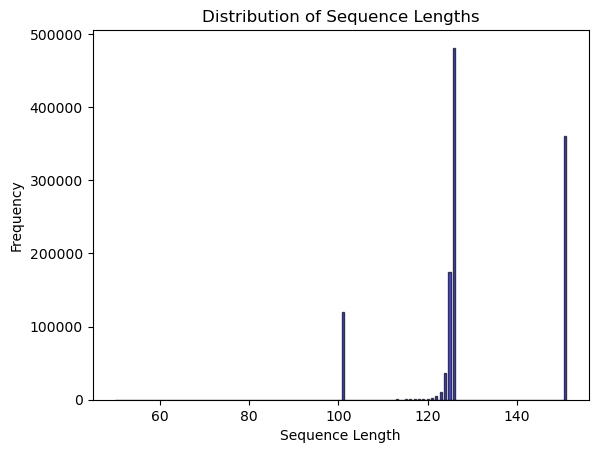

In [7]:
plt.hist(length, bins='auto', alpha=0.7, color='blue', edgecolor='black')
plt.title('Distribution of Sequence Lengths')
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.show()

### Prepare reads for input into the model

Remove sequences shorter than 100 bases

In [8]:
infile2 = infile[infile['sequence'].apply(len) >= 100]

Keep only the first 100 bases of each sequence

In [9]:
infile2['sequence'] = infile2['sequence'].str[:100]

C:\Users\matt_\anaconda3\envs\tf\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Check the number of sequences remaining

In [10]:
# Number of rows in dataframe
infile2.shape[0]

1196838

Remove sequences including Ns

In [11]:
infile2 = infile2[infile2['sequence'].str.contains("N")==False]

Check the number of sequences remaining

In [12]:
# Number of rows in dataframe
infile2.shape[0]

1195132

Remove sequences lacking any of the four bases (otherwise the following code fails; this can likely be fixed...)

In [13]:
# This can probably be done as a one-liner or a loop...
infile2 = infile2[infile2['sequence'].str.contains("A") &
              infile2['sequence'].str.contains("C") &
              infile2['sequence'].str.contains("G") &
              infile2['sequence'].str.contains("T")]

Check the number of sequences remaining

In [14]:
# Number of rows in dataframe
infile2.shape[0]

1195114

## Encoding

### Encoding of sequences

In [15]:
# The LabelEncoder encodes a sequence of bases as a sequence of integers.
integer_encoder = LabelEncoder()  
# The OneHotEncoder converts an array of integers to a sparse matrix where 
# each row corresponds to one possible value of each feature.
one_hot_encoder = OneHotEncoder(categories='auto')   
input_features = []

In [16]:
for sequence in infile2['sequence']:
  integer_encoded = integer_encoder.fit_transform(list(sequence))
  integer_encoded = np.array(integer_encoded).reshape(-1, 1)
  one_hot_encoded = one_hot_encoder.fit_transform(integer_encoded)
  input_features.append(one_hot_encoded.toarray())

Checking to ensure that each sequence has been correctly encoded as a 100x4 matrix  
This was an issue before removal of sequences that didn't contain all four bases

In [17]:
for sequence in input_features:
    if sequence.shape != (100, 4):
        print(sequence.shape)

In [18]:
np.set_printoptions(threshold=40)
input_features = np.stack(input_features)

In [19]:
print("Example sequence\n-----------------------")
print('DNA Sequence #1:\n',infile2['sequence'][0][:10],'...',infile2['sequence'][0][-10:])
print('One hot encoding of Sequence #1:\n',input_features[0].T)

Example sequence
-----------------------
DNA Sequence #1:
 GGCGCGGTTC ... GATCGCTGAT
One hot encoding of Sequence #1:
 [[0. 0. 0. ... 0. 1. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [1. 1. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]]


### Encoding of labels

In [20]:
labels = list(infile2['species'])

In [21]:
one_hot_encoder = OneHotEncoder(categories='auto')
labels = np.array(labels).reshape(-1, 1)
input_labels = one_hot_encoder.fit_transform(labels).toarray()

In [22]:
print('Labels:\n',labels.T)
print('One-hot encoded labels:\n',input_labels.T)

Labels:
 [['Antarctobacter' 'Antarctobacter' 'Antarctobacter' ... 'Sulfitobacter'
  'Sulfitobacter' 'Sulfitobacter']]
One-hot encoded labels:
 [[1. 1. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 1. 1.]]


Split the data into training and test sets
* Test dataset is 1/4 of the total (`test_size = 0.25`)
* Select a random seed for reproducibility (`random_state = 42`)
* Relative class frequencies are preserved between the subsets (`stratify = input_labels`)

In [23]:
train_features, test_features, train_labels, test_labels = train_test_split(
    input_features, input_labels,
    test_size=0.25,
    random_state=42,
    stratify=input_labels)

# Should we also shuffle the data...?
# train_test_split seems to have done the job for us?
# According to scikit-learn's manual page, train_test_split has shuffle=True as a default

### Select architecture and train

Building a CNN

We have ten categories to sort into, so will adjusting the last Dense layer to 10 work?

In [25]:
# From original Zou et al. script

#model = Sequential()
#model.add(Conv1D(filters=64, kernel_size=20, 
#                 input_shape=(train_features.shape[1], 4)))
#model.add(MaxPooling1D(pool_size=4))
#model.add(Flatten())
#model.add(Dense(16, activation='relu'))
#model.add(Dense(10, activation='softmax'))

#### Define the model architecture

Regarding activation functions:
* `softmax` - use in last layer to predict a class (i.e. calculate a probability) (range 0,1)
* `relu` - use in hidden layers (converts negative values to zero) (range 0, inf.)
* `tanh`
* `sigmoid`

Regarding layers of the CNN:
* `Conv1D` - Define the number of filters (`filters`) and their size (`kernel_size`)
   * Also define the shape of the input data (`input_shape`) in the first layer
* `MaxPooling1D` - Downsamples the input
   * In this case, selecting the maximum value in each 2x2 window
* `Flatten` - Flattens the input into a one-dimensional vector, for input into the Dense layer
* `Dense` - Densely-connected neural network layer, compressing down the input into (in this case) 16, then 10 tensors

In [27]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=128, kernel_size=10, input_shape=(train_features.shape[1], 4)),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Conv1D(filters=128, kernel_size=5),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Conv1D(filters=128, kernel_size=3),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

#### Set the optimisation function
Optimisation function adjusts network attributes (weights, learning rate, etc.) to reduce loss
* `Adam` is an adaptive optimiser
* Stochastic gradient descent (`SGD`)

The learning rate determines how much the weights in the network update; a smaller learning rate will update weights by a smaller amount each epoch compared to higher learning rates

In [28]:
# Custom optimiser function (Adam default is 0.001)
custom_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)

#### Compile the model
Define the loss function, optimisation function (see above), and the metric(s) to be evaluated
* `categorical_crossentropy` loss function is used for classification problems
* `CategoricalAccuracy` metric is used to determine "how often predictions match one-hot labels" (TensorFlow website)

In [29]:
#model.compile(loss='categorical_crossentropy', optimizer='adam', 
#              metrics=['CategoricalAccuracy'])
model.compile(loss='categorical_crossentropy',
              optimizer=custom_optimizer, 
              metrics=['CategoricalAccuracy'])

#### Display a table summary of the model structure

In [30]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 91, 128)           5248      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 45, 128)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 41, 128)           82048     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 20, 128)          0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 18, 128)           49280     
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 9, 128)           0

#### Define an early stopping callback
This is a measure against overfitting; if the validation loss starts increasing, the training will stop before the defined number of epochs are over
* `patience` determined how many epochs of worsening loss the model can encountered before training stops, just in case performance starts improving again

In [31]:
early_stopping = tf.keras.callbacks.EarlyStopping(patience=2,
                                                 restore_best_weights = True)

#### Train the model
* `verbose=2` returns a line of results per epoch
* `batch_size` determines how many samples passed through the network at a time
* `callbacks` defines a list of additional actions to perform during training
* `validation_split` defines the fraction of the training data to be used for validation at the end of the epoch

In [32]:
history = model.fit(train_features, train_labels, 
                    epochs=50,
                    verbose=2,
                    batch_size=5000,
                    callbacks=[early_stopping],
                    validation_split=0.1)

Epoch 1/50
162/162 - 161s - loss: 1.8517 - categorical_accuracy: 0.2567 - val_loss: 1.7505 - val_categorical_accuracy: 0.3036 - 161s/epoch - 993ms/step
Epoch 2/50
162/162 - 158s - loss: 1.6707 - categorical_accuracy: 0.3502 - val_loss: 1.6342 - val_categorical_accuracy: 0.3700 - 158s/epoch - 973ms/step
Epoch 3/50
162/162 - 163s - loss: 1.5851 - categorical_accuracy: 0.3973 - val_loss: 1.5597 - val_categorical_accuracy: 0.4054 - 163s/epoch - 1s/step
Epoch 4/50
162/162 - 168s - loss: 1.5388 - categorical_accuracy: 0.4183 - val_loss: 1.5201 - val_categorical_accuracy: 0.4292 - 168s/epoch - 1s/step
Epoch 5/50
162/162 - 159s - loss: 1.5042 - categorical_accuracy: 0.4352 - val_loss: 1.4902 - val_categorical_accuracy: 0.4431 - 159s/epoch - 982ms/step
Epoch 6/50
162/162 - 166s - loss: 1.4788 - categorical_accuracy: 0.4470 - val_loss: 1.4777 - val_categorical_accuracy: 0.4465 - 166s/epoch - 1s/step
Epoch 7/50
162/162 - 171s - loss: 1.4582 - categorical_accuracy: 0.4566 - val_loss: 1.4608 - val_

#### Plot the loss across the epochs

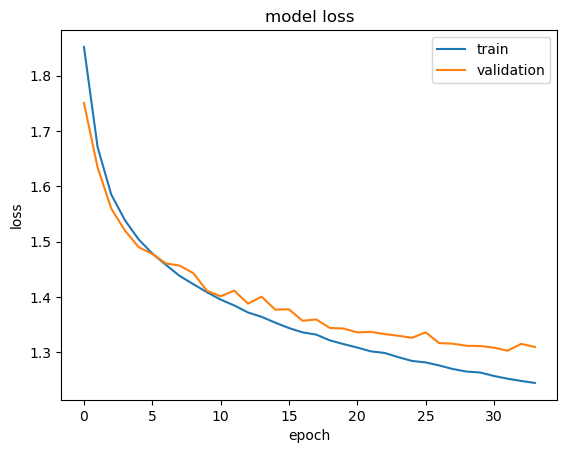

In [33]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

#### Plot the accuracy across the epochs

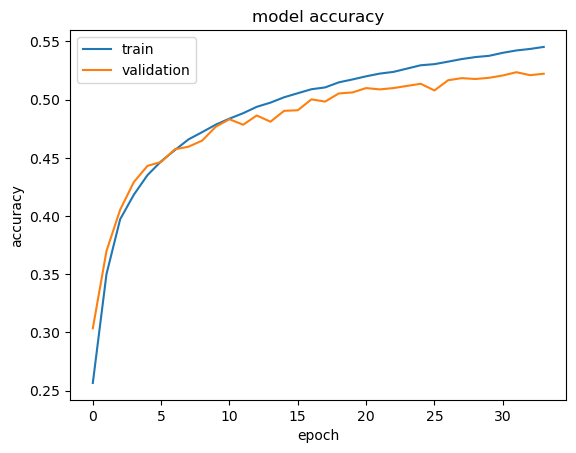

In [34]:
plt.figure()
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

### Evaluation

#### Test the trained model on the test dataset

In [35]:
test_loss, test_accuracy = model.evaluate(test_features, test_labels)

9337/9337 [==============================] - 38s 4ms/step - loss: 1.2998 - categorical_accuracy: 0.5232


In [36]:
print('\nTest loss: {0:.2f}. Test accuracy: {1:.2f}%'.format(test_loss, test_accuracy*100.))


Test loss: 1.30. Test accuracy: 52.32%


### Results summary

Batch 32 (default) - Test loss: 1.44. Test accuracy: 46.64%  
Batch 5000         - Test loss: 1.43. Test accuracy: 47.99%  
Add early stopping and increase filters from 32 to 64 - Test loss: 1.46. Test accuracy: 45.54%  
Lowered learning rate by half - Test loss: 1.38. Test accuracy: 48.94%  
Increase kernel size to 20 - Test loss: 1.43. Test accuracy: 46.54%  
Increase filters to 128 - Test loss: 1.41. Test accuracy: 47.80%  
Add another Conv/MaxPooling pair - Test loss: 1.35. Test accuracy: 49.90%  
Add stratification to train_test_split - Test loss: 1.33. Test accuracy: 51.08%  
Fiddle with the existing layers and add another pair - Test loss: 1.36. Test accuracy: 50.23%  
Lower validation_split from 0.25 to 0.1 - Test loss: 1.31. Test accuracy: 52.11%  
...

### Confusion matrix

In [37]:
predicted_labels = model.predict(np.stack(test_features))

9337/9337 [==============================] - 37s 4ms/step


In [38]:
cm = confusion_matrix(np.argmax(test_labels, axis=1), 
                      np.argmax(predicted_labels, axis=1))
print('Confusion matrix:\n',cm)

cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]

Confusion matrix:
 [[ 7281   169    48 ...   443  2408  3883]
 [   34 22617  3329 ...  2345   362    91]
 [    0  3893 22364 ...  3081   109    65]
 ...
 [   54  2292  2393 ... 21279   412   188]
 [  960   496    84 ...   606 18662   945]
 [ 3837   339   160 ...   807  2884  6310]]


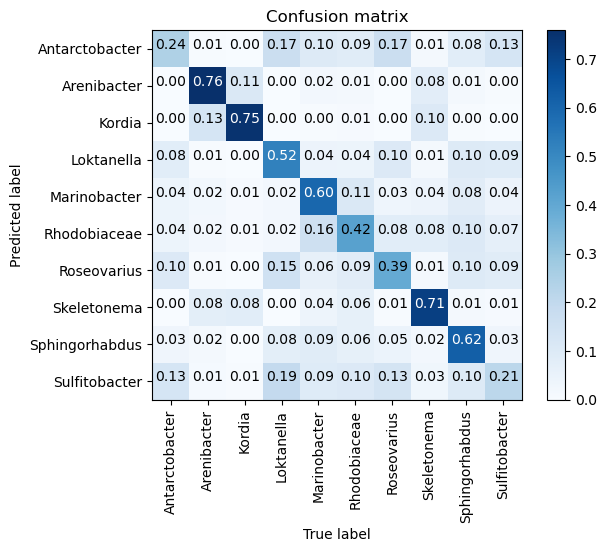

In [39]:
plt.imshow(cm, cmap=plt.cm.Blues)
plt.title('Confusion matrix')
plt.colorbar()
plt.xlabel('True label')
plt.ylabel('Predicted label')
plt.xticks(ticks=range(0,len(list(infile['species'].unique()))),
          labels=list(infile['species'].unique()),
          rotation='vertical')
plt.yticks(ticks=range(0,len(list(infile['species'].unique()))),
          labels=list(infile['species'].unique()))
plt.grid('off')
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], '.2f'),
             horizontalalignment='center',
             color='white' if cm[i, j] > 0.5 else 'black')

# Removes the white gridlines in the middle of the matrix
plt.grid(False)

### Interpretation

Your results so far should allow you to conclude that the neural network is quite effective in learning to distinguish sequences that bind the protein from sequences that do not. But can we understand why the neural network classifies a training point in the way that it does? To do so, we can compute a simple saliency map, which is the gradient of the model's prediction with respect to each individual nucleotide.

In other words, the saliency maps shows how the output response value changes with respect to a small changes in input nucleotide sequence. All the positive values in the gradients tell us that a small change to that nucleotide will change the output value. Hence, visualizing these gradients for a given input sequence, should provide some clues about what nucleotides form the binding motive that we are trying to identify.

    Note: the cells here have been adjusted as the code from the tutorial doesn't work
    (see https://github.com/abidlabs/deep-learning-genomics-primer/issues/6)

#### Still working on the cells below...

In [40]:
def compute_salient_bases(model, x):
    @tf.function
    def compute_gradients(x):
        with tf.GradientTape() as tape:
            tape.watch(x)
            logits = model(x)
            prob = logits[:, 1]  # Assuming binary classification, change the index if needed
        gradients = tape.gradient(prob, x)
        return gradients

    x_value = np.expand_dims(x, axis=0)
    gradients = compute_gradients(x_value)
    gradients = tf.where(gradients == None, tf.zeros_like(gradients), gradients)
    sal = tf.reduce_sum(gradients * x, axis=2)
    sal = tf.clip_by_value(sal, clip_value_min=0, clip_value_max=tf.reduce_max(sal))
    return sal.numpy()

In [41]:
sequence_index = 1999  # You can change this to compute the gradient for a different example. But if so, change the coloring below as well.
sal = compute_salient_bases(model, input_features[sequence_index])

NameError: name 'sequences' is not defined

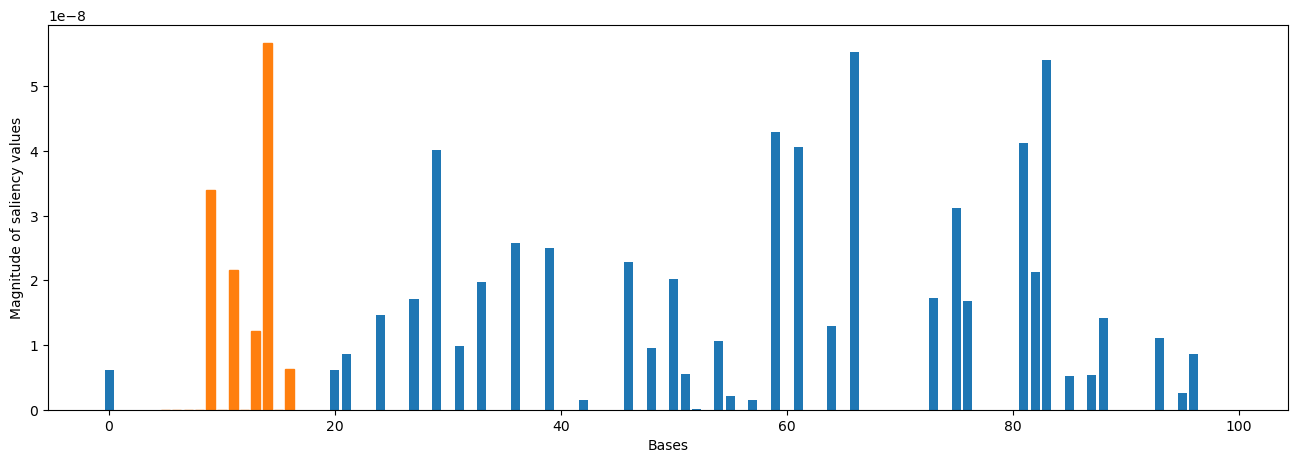

In [42]:
plt.figure(figsize=[16, 5])
barlist = plt.bar(np.arange(len(sal[0])), sal[0])
[barlist[i].set_color('C1') for i in range(5, 17)]  # Change the coloring here if you change the sequence index.
plt.xlabel('Bases')
plt.ylabel('Magnitude of saliency values')
plt.xticks(np.arange(len(sal[0])), list(sequences[sequence_index]))
plt.title('Saliency map for bases in one of the positive sequences'
          ' (green indicates the actual bases in the motif)')
plt.show()

The results above should show high saliency values for the bases CGACCGAACTCC appearing in the DNA sequence. If you recall from the top of the document, this is exactly the motif that we embedded in the positive sequences! The raw saliency values may be non-zero for other bases as well -- the gradient-based saliency map method is not perfect, and there other more complex interpretation methods that are used in practice to obtain better results.

Furthermore, we may explore other architectures for our neural network to see if we can improve performance on the validation dataset. For example, we could choose different hyper-parameters, which are variables that define the network structure (e.g. the number of dense or convolutional layers, the dimensionality of each layer, etc.) and variables that determine how the network is trained (e.g. the number of epochs, the learning rate, etc.). Testing different hyper-parameter values or performing a hyper-parameter search grid are good practices that may help the deep learning procedure to obtain a clearer signal for classifying sequences and identifying the binding motif.